In [13]:
import pickle, os 
from pathlib import Path 

with open("ratios.pickle", "rb") as f: 
    extinction_ratios = pickle.load(f) 

In [14]:
extinction_ratios

{'NRCB1': {'AF115W/AF212N': (3.344534245292499, 0.1156767142301079),
  'AF140M/AF212N': (2.3419269184527125, 0.09341853948756694),
  'AF212N/AF212N': (1.0, 0.0),
  'AF323N/AF212N': (0.9134131771431971, 0.08557307099325737),
  'AF405N/AF212N': (0.4603120119995674, 0.02706553776470757)},
 'NRCB2': {'AF115W/AF212N': (3.3230995555013885, 0.04418875805977559),
  'AF140M/AF212N': (2.520479757751345, 0.11322858171718167),
  'AF182M/AF212N': (1.2748075237681524, 0.04887609275350659),
  'AF212N/AF212N': (1.0, 0.0),
  'AF323N/AF212N': (0.6870369308233681, 0.09460294892679987),
  'AF405N/AF212N': (0.40740177599308874, 0.021904765635100028)},
 'NRCB3': {'AF115W/AF212N': (3.4408888739298744, 0.19867582250013238),
  'AF140M/AF212N': (2.5882428766589354, 0.15401490336986406),
  'AF182M/AF212N': (1.393518162618213, 0.08554073977157457),
  'AF212N/AF212N': (1.0, 0.0),
  'AF323N/AF212N': (0.8172431584019595, 0.09263693043509437),
  'AF405N/AF212N': (0.39927422785547384, 0.05543405263522338)},
 'NRCB4': 

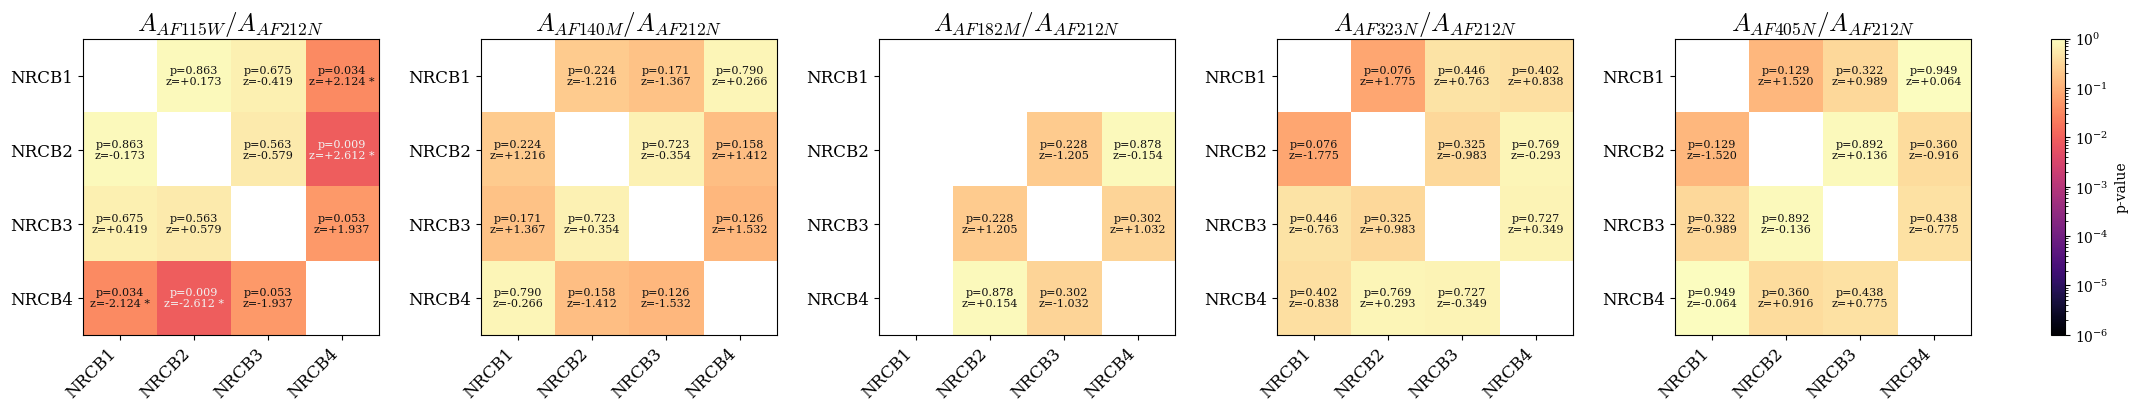

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import norm

plt.rcParams['font.family']      = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

def plot_pairwise(ratio_dict: dict, alpha=0.05):
    regions = list(ratio_dict.keys())

    all_ratios = sorted(
        {k for r in regions for k in ratio_dict[r].keys() if k != "AF212N/AF212N"},
        key=lambda s: float(''.join(ch for ch in s.split('/')[0] if ch.isdigit())) / 100
    )

    n_reg = len(regions)
    n_rat = len(all_ratios)

    figure, axis = plt.subplots(
        1, n_rat, figsize=(4*n_rat + 1.5, 4),
        constrained_layout=True
    )
    axes = np.atleast_1d(axis)

    def latex_label(k):
        num, den = k.split('/')
        return rf"$A_{{{num}}}/A_{{{den}}}$"

    for ax, ratio in zip(axes, all_ratios):
        vals  = [ratio_dict[reg].get(ratio) for reg in regions]
        mu    = np.array([v[0] if v is not None else np.nan for v in vals])
        sigma = np.array([v[1] if v is not None else np.nan for v in vals])

        denom   = np.sqrt(sigma[:, None]**2 + sigma[None, :]**2)
        z_score = (mu[:, None] - mu[None, :]) / denom
        p_score = 2.0 * norm.sf(np.abs(z_score))

        np.fill_diagonal(z_score, np.nan)
        np.fill_diagonal(p_score, np.nan)

        p_plot = np.where(np.isnan(p_score), np.nan, np.clip(p_score, 1e-12, 1.0))

        im = ax.imshow(
            p_plot,
            norm=LogNorm(vmin=1e-6, vmax=1),
            cmap="magma",
        )

        for i in range(n_reg):
            for j in range(n_reg):
                if i == j or not np.isfinite(p_score[i, j]):
                    continue
                star = " *" if p_score[i, j] < alpha else ""
                ax.text(
                    j, i,
                    f"p={p_score[i,j]:.3f}\nz={z_score[i,j]:+0.3f}{star}",
                    ha="center", va="center",
                    fontsize=8,
                    color="#f2f2f2" if p_score[i, j] < 0.01 else "#111111",
                )

        ax.set_xticks(range(n_reg), regions, rotation=45, ha="right", fontsize=12)
        ax.set_yticks(range(n_reg), regions, fontsize=12)
        ax.set_title(latex_label(ratio), fontsize=18)

    cbar = figure.colorbar(im, ax=axes.ravel().tolist(), pad=0.04)
    cbar.set_label("p-value")
    plt.savefig("heatmap", dpi=300)

plot_pairwise(extinction_ratios)